# Pre-requirements


# Libraries and some funtion defination

In [1]:
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
import pandas as pd
# Bibliotecas Auxiliares
import seaborn as sns
import numpy as np
import collections
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()
import tensorflow_federated as tff
np.random.seed(0)
from collections import Counter

import collections
import functools
import os
import time
import datetime

from sklearn.model_selection import train_test_split

# library to ignore the warnings
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

2023-06-13 14:34:38.716520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 14:34:39.572762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = confusion_matrix(y_test, yhat_classes)
    print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = np.array(matrix,dtype=object)
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

def showGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

# Data Loading and Analysis

In this setion, we load analyse the data and do the transformations needed to prepare the data. As neural networks need numeric values, we must always be sure that all values are numbers.

In [3]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolders = "../data_2019_processed/"
            
allFolders = ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
            '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
            '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
            '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
            #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
            '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
            'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
            'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
            'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
            'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
            'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
            #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
            'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
            'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
            'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
            'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
            'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
            'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
            'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
            #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
            'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
            'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
            'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
            'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4', 
            'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
            'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
            'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
            'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
            'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
            'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']


# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']


In [4]:
print("Preparing test data")
# take the list of directories and concat them
def loadTestData(trainingDataSet):
    print(len(trainingDataSet), "datasets")
    for i in range(0,len(trainingDataSet)):
        print(i , "-", trainingDataSet[i])
        #print(trainingDataSet[i])
        if(i == 0):
            X_test = pd.read_csv(inputFolders+"student_"+trainingDataSet[i]+"_transformed.csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+trainingDataSet[i]+"_transformed.csv")
            X_test = pd.concat([X_test, dataset])
    # return the dataset        
    return X_test
         
# test data comprising 25% of the data. It must be fixed to all models being evaluated
#X_test  = pd.read_csv(inputFolders+"test/allData-classification-numeric-normalized.csv")
X_test = loadTestData(testFolders)

print()
# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
9 datasets
0 - PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc
1 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw
2 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI
3 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is
4 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw
5 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA
6 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw
7 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM
8 - ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136286 entries, 0 to 23751
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            136286 non-null  float64
 1   location            136286 non-null  float64
 2   timestamp           136286 non-null  float64
 3   time_to_next_alarm  136286 non-null  float64
 4   sound               136286 non-null  float64
 5   proximity           136286 non-null  float64
 6   phone_lock          1362

,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class
0,0.00,1.0,0.000000e+00,0.906151,0.655565,1.0,0.0,0.000000,1.000000,0.115358,2018-05-15 02:46:57,awake
1,0.25,1.0,0.000000e+00,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:27,awake
2,0.25,1.0,3.211588e-07,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:57,awake
3,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:28,awake
4,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:57,awake
...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37,awake
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08,awake
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08,awake
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38,awake


In [5]:
# load cliend data to train
clientList = []

for i in range(0,len(trainFolders)):
    print (i," ", str(inputFolders)+"student_"+trainFolders[i]+"_transformed.csv") #_numeric
    # load client data
    dataset = pd.read_csv(inputFolders+"student_"+trainFolders[i]+"_transformed.csv")
    
    # print(dataset)
    y_train = dataset['class'].copy()
    
    # does not add datasets that dont have instances from both classes
    if y_train.sum() != 0 and (y_train.sum() != len(y_train)):
        clientList.append(dataset)
        
print("Total",(len(clientList)))

0   ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_transformed.csv
1   ../data_2019_processed/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA_transformed.csv
2   ../data_2019_processed/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0_transformed.csv
3   ../data_2019_processed/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys_transformed.csv
4   ../data_2019_processed/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA_transformed.csv
5   ../data_2019_processed/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4_transformed.csv
6   ../data_2019_processed/student_ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc_transformed.csv
7   ../data_2019_processed/student_Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U_transformed.csv
8   ../data_2019_processed/student_CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA_transformed.csv
9   ../data_2019_processed/student_DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc_transformed.csv
10   ../data_2019_processed/student_dQEFscjqnIlug8Tgq97JohhS

# Pre-processing

As we saw in the previous section, our dataset has 12 attributes, which we must prepare for the preprocessing task.

In order to do it, we are going to apply the following methodology:
- Feature Selection
- Data encoding transformation
- Feature data type transformation

From our dataset, we need to select the inputs and the outputs from our supervised learning process. From all 12 features, the class is the output, and the input does not need the timestamp and timestamp_text features because they are time-related value and (usually) does not give benefits to the neural network learning process. Thus, we create two new lists of values with the output classes we want: *inputFeatures* and *outputClasses*.

As we are using a process of classification and our output (class) can get two values awake and asleep, we can choose between two approaches:
(1) convert the class using label encoding (0 to awake and 1 to asleep). In this scenario, we use Binary Cross Entropy.
(2) convert the class using one-hot encoding, which becomes two different attributes. In this scenario, we use Categorical Cross Entropy.

In federated learning, I judge easier to use one-hot encoding in such a situation.

*Curiosity*: If you want to check the influence of timestamp in your dataset, you can use the pearson correlation or compare the training process results with and without it.

In [6]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]


In [7]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

# transform output to one_hot_encoding for the input dataset
for i in range(0,len(clientList)):
    clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
    #print (clientList[i])

In [8]:
X_test

,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class,awake,asleep
0,0.00,1.0,0.000000e+00,0.906151,0.655565,1.0,0.0,0.000000,1.000000,0.115358,2018-05-15 02:46:57,awake,1,0
1,0.25,1.0,0.000000e+00,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:27,awake,1,0
2,0.25,1.0,3.211588e-07,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:57,awake,1,0
3,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:28,awake,1,0
4,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:57,awake,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37,awake,1,0
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08,awake,1,0
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08,awake,1,0
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38,awake,1,0


As FedAvg uses float of 32 bits I recommend convert all values numeric values to float32


In [9]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136286 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            136286 non-null  float32
 1   location            136286 non-null  float32
 2   timestamp           136286 non-null  float64
 3   time_to_next_alarm  136286 non-null  float32
 4   sound               136286 non-null  float32
 5   proximity           136286 non-null  float32
 6   phone_lock          136286 non-null  float32
 7   light               136286 non-null  float32
 8   day_of_week         136286 non-null  float32
 9   minutes_day         136286 non-null  float32
 10  timestamp_text      136286 non-null  object 
 11  class               136286 non-null  object 
 12  awake               136286 non-null  float32
 13  asleep              136286 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 9.9+ MB


In [10]:
X_test

,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class,awake,asleep
0,0.00,1.0,0.000000e+00,0.906151,0.655565,1.0,0.0,0.000000,1.000000,0.115358,2018-05-15 02:46:57,awake,1.0,0.0
1,0.25,1.0,0.000000e+00,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:27,awake,1.0,0.0
2,0.25,1.0,3.211588e-07,0.906052,0.567296,1.0,0.0,0.000000,1.000000,0.116053,2018-05-15 02:47:57,awake,1.0,0.0
3,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:28,awake,1.0,0.0
4,0.25,1.0,3.211588e-07,0.905952,0.660604,1.0,0.0,0.000000,1.000000,0.116748,2018-05-15 02:48:57,awake,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37,awake,1.0,0.0
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08,awake,1.0,0.0
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08,awake,1.0,0.0
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38,awake,1.0,0.0




Now I need to transform the data into Tensor Slices. This slices can consider configurations as like: batch_size, window and epochs.

In [11]:
# General configuration
NUM_EPOCHS = 1
BATCH_SIZE = 32

In [12]:
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transtorm data to tensor slices
client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data.values, y_test_label.values))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

print(client_test_dataset.element_spec)
client_test_dataset

(TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))


2023-06-13 14:34:45.360907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:45.436136: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [13]:
federated_training_data = []
# transform the data
for i in range(0,len(clientList)):
    # selects the data to train and test
    data   = clientList[i][inputFeatures]
    labels = clientList[i][outputClasses]
    # transform the data to tensor slices
    client_train_dataset = tf.data.Dataset.from_tensor_slices((data.values, labels.values))
    # apply the configs
    client_train_dataset = client_train_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)
    # transform the data to
    federated_training_data.append(client_train_dataset)

# Model processing

In [14]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(9,)),
      #tf.keras.layers.Dense(9, activation=tf.keras.activations.relu), 
      tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
      #tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
    ])

In [15]:
keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [16]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    #keras_model = create_keras_model()
    keras_model = create_keras_model()
    # on mac or tff 0.40: tff.learning.from_keras_model, others tff.learning.models.from_keras_model
    return tff.learning.models.from_keras_model( 
      keras_model,
      input_spec=client_train_dataset.element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(), #BinaryCrossentropy
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [17]:
fed_avg_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),#client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [18]:
print(fed_avg_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9,16],
      float32[16],
      float32[16,8],
      float32[8],
      float32[8,2],
      float32[2]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[9,16],
    float32[16],
    float32[16,8],
    float32[8],
    float32[8,2],
    float32[2]
  >
>@SERVER)


In [19]:
state = fed_avg_process.initialize()

2023-06-13 14:34:50.903408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:50.903459: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:34:50.903956: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:34:50.905161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:50.905187: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

# First Iteractions (rounds)

Now, we can start the learning process by selecting the users participating in the fed-avg aggregation process. Round 1 uses the data from the first ten users ([0:10]), and Round 2 uses the nine [10:19] remaining users for training.

We must highlight that it is an example. Nineteen users are too few to separate them, but it would be different if we considered much more users or data. In such scenarios, we must determine the selection strategy.

In [20]:
# now we can start the learning process by selecting the users that will participate from the learning process
result = fed_avg_process.next(state, federated_training_data[0:10])
state = result.state
metrics = result.metrics
print('round  1, metrics={}'.format(metrics))

2023-06-13 14:34:53.824364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:53.824423: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:34:53.824537: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:34:53.825133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:53.825154: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

2023-06-13 14:34:54.026779: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:34:54.026841: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:34:54.027245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:54.027259: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-13 14:34:54.050499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open fi

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.85739267), ('loss', 0.3559808), ('num_examples', 191007), ('num_batches', 5975)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


After the aggregation process is finished, we can see the results by loading the neural network weights from the global model.

In [21]:
#def keras_evaluate(state, round_num):
    # Take our global model weights and push them back into a Keras model to
    # use its standard `.evaluate()` method.
keras_model = create_keras_model()

keras_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])

# get neural network weights from the global model
weights = fed_avg_process.get_model_weights(state)
weights.assign_weights_to(keras_model)

# predict using the test data
yhat_probs = keras_model.predict(X_test_data)

maxX = yhat_probs.max()
minX = yhat_probs.min()
avgX = yhat_probs.mean()

print(maxX,minX,avgX,"\n")
print(yhat_probs)
# predict crisp classes for test set deprecated
#printMetrics(y_test,yhat_probs)

# as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
yhat_probs_rounded = yhat_probs.round()
print("\n",yhat_probs_rounded)

y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 

# Instantiate the list that will contain the results
listOfMetrics = list()

print('')
print('awake')
res,resA = printMetrics(y_test_label['awake'],y_predicted_df['awake'])
listOfMetrics.append(res)
print('')
print('asleep')
res,resA = printMetrics(y_test_label['asleep'],y_predicted_df['asleep'])
listOfMetrics.append(res)
print('')
print('Global')
showGlobalMetrics(listOfMetrics)

   1/4259 [..............................] - ETA: 7:12

2023-06-13 14:34:55.463403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:55.463488: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 14:34:55.463653: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 14:34:55.464603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 14:34:55.464671: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

4259/4259 [==============================] - 3s 671us/step
0.9647559 0.03524415 0.5 

[[0.887978   0.11202205]
 [0.8967815  0.1032185 ]
 [0.8967815  0.1032185 ]
 ...
 [0.84550613 0.1544939 ]
 [0.84550536 0.15449463]
 [0.8170588  0.18294117]]

 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

awake
Accuracy: 0.815572
Precision: 0.815572
Recall: 1.000000
F1 score: 0.898419
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[     0  25135]
 [     0 111151]]

asleep
Accuracy: 0.815572
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[111151      0]
 [ 25135      0]]

Global
2
accuracy:  0.8155716654682066
precision:  0.4077858327341033
recall:  0.5
f1_score:  0.44920929367879503
cohen_kappa_score:  0.0
roc_auc_score:  0.5


[0.8155716654682066, 0.4077858327341033, 0.5, 0.44920929367879503, 0.0, 0.5]

In [22]:
result = fed_avg_process.next(state, federated_training_data[10:19])
state = result.state
metrics = result.metrics
print('round  2, metrics={}'.format(metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.84974015), ('loss', 0.3504369), ('num_examples', 216445), ('num_batches', 6770)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [23]:
#def keras_evaluate(state, round_num):
    # Take our global model weights and push them back into a Keras model to
    # use its standard `.evaluate()` method.
keras_model = create_keras_model()

keras_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])

# get neural network weights from the global model
weights = fed_avg_process.get_model_weights(state)
weights.assign_weights_to(keras_model)

# predict using the test data
yhat_probs = keras_model.predict(X_test_data)

maxX = yhat_probs.max()
minX = yhat_probs.min()
avgX = yhat_probs.mean()

print(maxX,minX,avgX,"\n")
print(yhat_probs)

# as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
yhat_probs_rounded = yhat_probs.round()
print("\n",yhat_probs_rounded)

# create a dataframe with the predicted data
y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 

# Instantiate the list that will contain the results
listOfMetrics = list()

print('')
print('awake')
res,resA = printMetrics(y_test_label['awake'],y_predicted_df['awake'])
listOfMetrics.append(res)
print('')
print('asleep')
res,resA = printMetrics(y_test_label['asleep'],y_predicted_df['asleep'])
listOfMetrics.append(res)
print('')
print('Global')
showGlobalMetrics(listOfMetrics)

4259/4259 [==============================] - 3s 675us/step
0.99152315 0.008476871 0.5 

[[0.9368646  0.06313541]
 [0.9435588  0.05644112]
 [0.9435588  0.05644112]
 ...
 [0.88595694 0.11404303]
 [0.8859553  0.11404479]
 [0.8517526  0.1482474 ]]

 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

awake
Accuracy: 0.815572
Precision: 0.815572
Recall: 1.000000
F1 score: 0.898419
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[     0  25135]
 [     0 111151]]

asleep
Accuracy: 0.815572
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[111151      0]
 [ 25135      0]]

Global
2
accuracy:  0.8155716654682066
precision:  0.4077858327341033
recall:  0.5
f1_score:  0.44920929367879503
cohen_kappa_score:  0.0
roc_auc_score:  0.5


[0.8155716654682066, 0.4077858327341033, 0.5, 0.44920929367879503, 0.0, 0.5]

# Example do script to experiments

Bellow we have a example of script that we can use to execute in a experiment to monitoring the metric improvement for each Round/Iteration

In [24]:
roundData = []

columns = ['NN_type','neurons','epochs','batch_size','max_iterations','Users',
           'round_iteration','start_time','end_time','round_time_s','round_time_m',
           'class','accuracy','precision','recall','f1_score','cohen_kappa_score','roc_auc_score','confusion_matrix',
           'TP','FP','FN','TN']

# maximun number the Rounds\Iteractions
MAX_ITERATIONS = 30 # 120
#NUM_EPOCHS
#BATCH_SIZE
NN_type = 'MLP'
UNITS_NUMBER = "16/8"
USER_NUMBER = len(trainFolders)

generalData = [NN_type,UNITS_NUMBER,NUM_EPOCHS,BATCH_SIZE,MAX_ITERATIONS,USER_NUMBER]

for i in range(0,MAX_ITERATIONS):
    current_time_start = datetime.datetime.now()
    time_stamp_start = current_time_start.timestamp()
    print(i,"Start timestamp:", time_stamp_start,current_time_start)
    
    result = fed_avg_process.next(state, federated_training_data[0:19])
    state = result.state
    metrics = result.metrics
    print('round  {}, metrics={}'.format(i,metrics))

    print('')
    #def keras_evaluate(state, round_num):
        # Take our global model weights and push them back into a Keras model to
        # use its standard `.evaluate()` method.
    keras_model = create_keras_model()


    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

    # get neural network weights
    weights = fed_avg_process.get_model_weights(state)
    weights.assign_weights_to(keras_model)


    # predict values
    yhat_probs = keras_model.predict(X_test_data)
    
    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()
    
    

    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake','asleep']) 
    #y_test_label_label = pd.DataFrame(data=y_test_label,columns=['awake','asleep']) 
    
    # generate time metrics
    current_time_end = datetime.datetime.now()
    time_stamp_end = current_time_end.timestamp()
    processing_time_s = (time_stamp_end-time_stamp_start)
    
    # Instantiate the list that will contain the results
    listOfMetrics = list()
    
    # generate general metrics
    rowData = [i,current_time_start,current_time_end,processing_time_s,(processing_time_s)/60]

    print('')
    print('awake')    
    res,resA = printMetrics(y_test_label['awake'],y_predicted_df['awake'])
    listOfMetrics.append(res)
   
    #columns = ['NN_type','units','epochs','batch_size','max_iterations',''Users',
    #            round_iteration','start_time','end_time','round_time_s','round_time_m',
    #           'class','accuracy','precision','recall','f1_score','cohen_kappa_score','roc_auc_score','confusion_matrix',
    #           'TP','FP','FN','TN']
    # new data
    classData = np.concatenate((['awake'], resA))
    classData = np.concatenate((rowData, classData))
    classData = np.concatenate((generalData, classData))
    roundData.append(classData)
    
    print('')
    print('asleep')
    res,resA = printMetrics(y_test_label['asleep'],y_predicted_df['asleep'])
    listOfMetrics.append(res)
    # new data
    classData = np.concatenate((['asleep'], resA))
    classData = np.concatenate((rowData, classData))
    classData = np.concatenate((generalData, classData))
    roundData.append(classData)
    print('')
    print('Global')
    resA = showGlobalMetrics(listOfMetrics) #return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score
    # new data
    classData = np.concatenate((['avg'], resA))
    classData = np.concatenate((rowData, classData))
    classData = np.concatenate((generalData, classData))
    roundData.append(classData)
    print('')
    print(i,"End timestamp:", time_stamp_end,current_time_end)
    print('')
    print('')

0 Start timestamp: 1686663305.235941 2023-06-13 14:35:05.235941
round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8741447), ('loss', 0.30865997), ('num_examples', 407452), ('num_batches', 12745)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

4259/4259 [==============================] - 3s 674us/step

awake
Accuracy: 0.815572
Precision: 0.815572
Recall: 1.000000
F1 score: 0.898419
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[     0  25135]
 [     0 111151]]

asleep
Accuracy: 0.815572
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
\Confusion Matrix
[[111151      0]
 [ 25135      0]]

Global
2
accuracy:  0.8155716654682066
precision:  0.4077858327341033
recall:  0.5
f1_score:  0.44920929367879503
cohen_kappa_score:  0.0
roc_auc_score:  0.5

0 End timestamp

[[     7  25128]
 [     4 111147]]

asleep
Accuracy: 0.815594
Precision: 0.636364
Recall: 0.000278
F1 score: 0.000557
Cohens kappa: 0.000395
ROC AUC: 0.500121
\Confusion Matrix
[[111147      4]
 [ 25128      7]]

Global
2
accuracy:  0.8155936780006751
precision:  0.7259858908290389
recall:  0.5001212545201544
f1_score:  0.4494914723517234
cohen_kappa_score:  0.0003954577737973475
roc_auc_score:  0.5001212545201544

7 End timestamp: 1686663349.906465 2023-06-13 14:35:49.906465


8 Start timestamp: 1686663350.39341 2023-06-13 14:35:50.393410
round  8, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8762873), ('loss', 0.303113), ('num_examples', 407452), ('num_batches', 12745)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

4259/4259 [==============================] - 3s 695us/step

awake
Accuracy: 0.815535
Precision: 0.815570
Re

round  15, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8801699), ('loss', 0.29221353), ('num_examples', 407452), ('num_batches', 12745)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

4259/4259 [==============================] - 3s 740us/step

awake
Accuracy: 0.815535
Precision: 0.815764
Recall: 0.999568
F1 score: 0.898361
Cohens kappa: 0.002081
ROC AUC: 0.500639
\Confusion Matrix
[[    43  25092]
 [    48 111103]]

asleep
Accuracy: 0.815535
Precision: 0.472527
Recall: 0.001711
F1 score: 0.003409
Cohens kappa: 0.002081
ROC AUC: 0.500639
\Confusion Matrix
[[111103     48]
 [ 25092     43]]

Global
2
accuracy:  0.8155349779140925
precision:  0.6441458171037083
recall:  0.50063945845908
f1_score:  0.4508850906918803
cohen_kappa_score:  0.002081340890899175
roc_auc_score:  0.50063945845908

15 End timestamp: 1686663394.842742 

[[  2328  22807]
 [   866 110285]]

asleep
Accuracy: 0.826299
Precision: 0.728867
Recall: 0.092620
F1 score: 0.164355
Cohens kappa: 0.128094
ROC AUC: 0.542414
\Confusion Matrix
[[110285    866]
 [ 22807   2328]]

Global
2
accuracy:  0.8262991062911818
precision:  0.7787519792477484
recall:  0.5424143249183847
f1_score:  0.5337152916375558
cohen_kappa_score:  0.12809429563648866
roc_auc_score:  0.5424143249183848

22 End timestamp: 1686663433.213077 2023-06-13 14:37:13.213077


23 Start timestamp: 1686663433.684657 2023-06-13 14:37:13.684657
round  23, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8904583), ('loss', 0.2703441), ('num_examples', 407452), ('num_batches', 12745)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

4259/4259 [==============================] - 3s 685us/step

awake
Accuracy: 0.833681
Precision: 0.837617

In [25]:
dataMetrics = pd.DataFrame(data=roundData,columns=columns) 

dataMetrics

,NN_type,neurons,epochs,batch_size,max_iterations,Users,round_iteration,start_time,end_time,round_time_s,...,precision,recall,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix,TP,FP,FN,TN
0,MLP,16/8,1,32,30,19,0,2023-06-13 14:35:05.235941,2023-06-13 14:35:10.392983,5.157042,...,0.8155716654682066,1.0,0.8984185873575901,0.0,0.5,[[ 0 25135][ 0 111151]],0,25135,0,111151
1,MLP,16/8,1,32,30,19,0,2023-06-13 14:35:05.235941,2023-06-13 14:35:10.392983,5.157042,...,0.0,0.0,0.0,0.0,0.5,[[ 111151 0][ 25135 0]],111151,0,25135,0
2,MLP,16/8,1,32,30,19,0,2023-06-13 14:35:05.235941,2023-06-13 14:35:10.392983,5.157042,...,0.4077858327341033,0.5,0.44920929367879503,0.0,0.5,None,None,None,None,None
3,MLP,16/8,1,32,30,19,1,2023-06-13 14:35:10.845736,2023-06-13 14:35:15.636505,4.790769,...,0.8155716654682066,1.0,0.8984185873575901,0.0,0.5,[[ 0 25135][ 0 111151]],0,25135,0,111151
4,MLP,16/8,1,32,30,19,1,2023-06-13 14:35:10.845736,2023-06-13 14:35:15.636505,4.790769,...,0.0,0.0,0.0,0.0,0.5,[[ 111151 0][ 25135 0]],111151,0,25135,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,MLP,16/8,1,32,30,19,28,2023-06-13 14:37:40.308761,2023-06-13 14:37:45.255777,4.947016,...,0.6672849193893565,0.18607519395265565,0.29100298656047785,0.2289913751449082,0.582547362970336,[[ 108819 2332][ 20458 4677]],108819,2332,20458,4677
86,MLP,16/8,1,32,30,19,28,2023-06-13 14:37:40.308761,2023-06-13 14:37:45.255777,4.947016,...,0.754517789413035,0.5825473629703359,0.5981068470659876,0.2289913751449082,0.5825473629703359,None,None,None,None,None
87,MLP,16/8,1,32,30,19,29,2023-06-13 14:37:45.751635,2023-06-13 14:37:50.878834,5.127199,...,0.8416901059221894,0.9772831553472303,0.9044328248850996,0.2270065548439757,0.5822162743117691,[[ 4704 20431][ 2525 108626]],4704,20431,2525,108626
88,MLP,16/8,1,32,30,19,29,2023-06-13 14:37:45.751635,2023-06-13 14:37:50.878834,5.127199,...,0.6507124083552358,0.18714939327630795,0.2906933629959214,0.2270065548439757,0.5822162743117691,[[ 108626 2525][ 20431 4704]],108626,2525,20431,4704


In [27]:
# write file
outputMetricFile = "Results_MLP_unbalanced_" + str(NUM_EPOCHS) + "_epoch_" + str(MAX_ITERATIONS) + "_rounds_01.csv"
dataMetrics.to_csv(outputMetricFile, sep=',', encoding='utf-8', index=False)

In [28]:
dsMetrics = pd.read_csv(outputMetricFile)
print(dsMetrics.columns)

metrics = ["round_iteration","accuracy","precision","recall","f1_score"]

Index(['NN_type', 'neurons', 'epochs', 'batch_size', 'max_iterations', 'Users',
       'round_iteration', 'start_time', 'end_time', 'round_time_s',
       'round_time_m', 'class', 'accuracy', 'precision', 'recall', 'f1_score',
       'cohen_kappa_score', 'roc_auc_score', 'confusion_matrix', 'TP', 'FP',
       'FN', 'TN'],
      dtype='object')


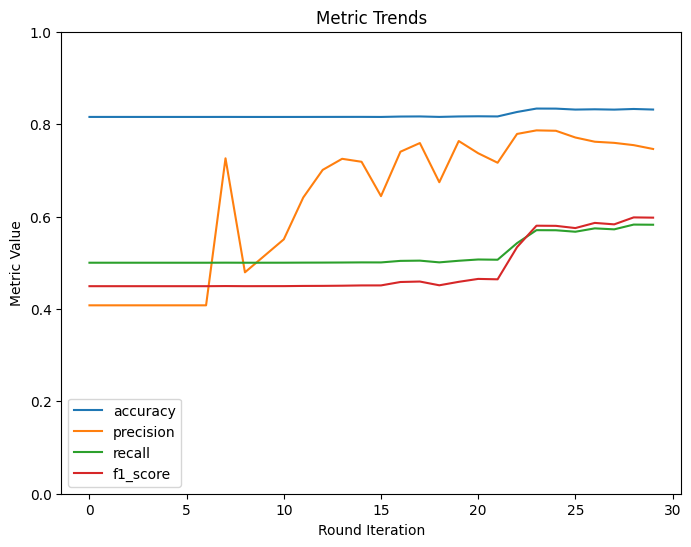

In [29]:
df = pd.DataFrame(dsMetrics.loc[dsMetrics['class'] == "avg"][metrics])

# Set the 'round_iteration' column as the index (optional)
df.set_index('round_iteration', inplace=True)

# Plot the line plot
ax = df.plot(kind='line',  figsize=(8, 6))
ax.set_ylim(0, 1)

# Set the labels and title
plt.xlabel('Round Iteration')
plt.ylabel('Metric Value')
plt.title('Metric Trends')

# Display the plot
plt.show()

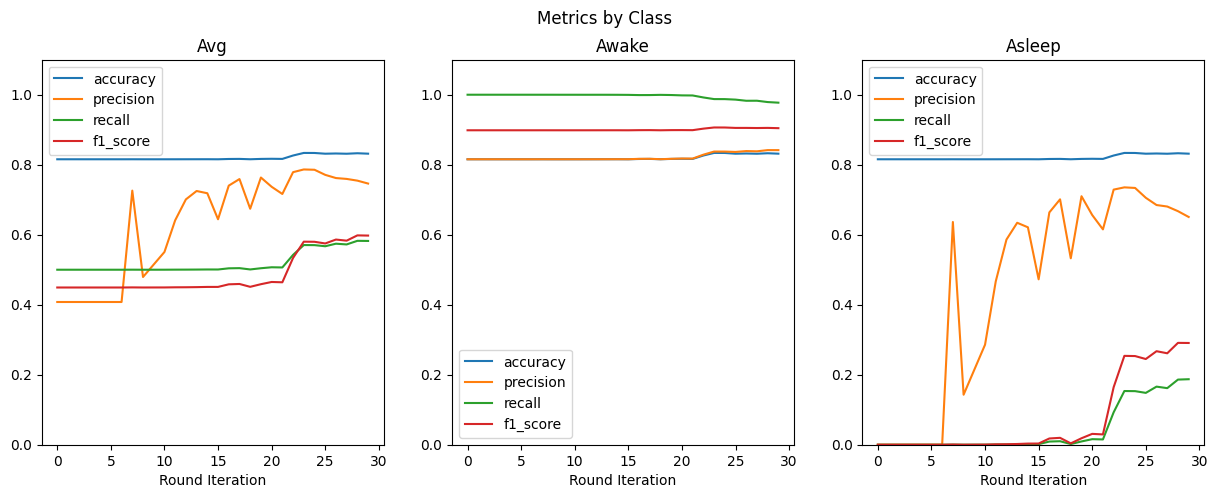

In [30]:
import matplotlib.pyplot as plt

# Define the metrics and classes to plot
metrics = ['round_iteration', 'accuracy', 'precision', 'recall', 'f1_score']
classes = ['avg', 'awake', 'asleep']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Loop through the classes and plot each one on a different subplot
for i, class_name in enumerate(classes):
    # Filter the data for the current class
    df_class = dsMetrics.loc[dsMetrics['class'] == class_name]
    
    # Plot the metrics on the current subplot
    df_class[metrics].plot.line(x='round_iteration', ax=axes[i])
    axes[i].set_title(class_name.capitalize())
    axes[i].set_xlabel('Round Iteration')
    axes[i].set_ylim([0, 1.1])
    
# Add a title for the entire plot
plt.suptitle('Metrics by Class')

# Show the plot
plt.show()